In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
# Define the paths to train and test folders
train_folder = r'C:\Users\ahmed\Downloads\archive\train'
test_folder = r'C:\Users\ahmed\Downloads\archive\test'
emotion_categories = ['surprise', 'sad', 'neutral', 'happy', 'fear', 'disgust', 'angry']

# Initialize lists to store training and test images and labels
train_image_data = []
train_labels = []
test_image_data = []
test_labels = []

# Load training data
for label, category in enumerate(emotion_categories):
    category_path = os.path.join(train_folder, category)
    for img_file in os.listdir(category_path):
        img_path = os.path.join(category_path, img_file)
        
        # Load image, convert to grayscale, resize, and normalize
        img = cv2.imread(img_path)
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_resized = cv2.resize(img_gray, (48, 48))  # Resize to 48x48
        img_normalized = img_resized / 255.0  # Normalize to [0, 1]
        
        train_image_data.append(img_normalized)
        train_labels.append(label)

# Load test data
for label, category in enumerate(emotion_categories):
    category_path = os.path.join(test_folder, category)
    for img_file in os.listdir(category_path):
        img_path = os.path.join(category_path, img_file)
        
        # Load image, convert to grayscale, resize, and normalize
        img = cv2.imread(img_path)
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_resized = cv2.resize(img_gray, (48, 48))  # Resize to 48x48
        img_normalized = img_resized / 255.0  # Normalize to [0, 1]
        
        test_image_data.append(img_normalized)
        test_labels.append(label)

# Convert to numpy arrays
train_image_data = np.array(train_image_data).reshape(-1, 48, 48, 1)  # Reshape for CNN input
train_labels = np.array(train_labels)

test_image_data = np.array(test_image_data).reshape(-1, 48, 48, 1)  # Reshape for CNN input
test_labels = np.array(test_labels)

# One-hot encode labels
train_labels = to_categorical(train_labels, num_classes=len(emotion_categories))
test_labels = to_categorical(test_labels, num_classes=len(emotion_categories))

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_image_data, train_labels, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}, Validation data shape: {X_val.shape}, Test data shape: {test_image_data.shape}")

Training data shape: (22967, 48, 48, 1), Validation data shape: (5742, 48, 48, 1), Test data shape: (7178, 48, 48, 1)


In [4]:
# Build the Model
# Create a CNN model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(emotion_categories), activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 128)        0

In [ ]:
# Train the Model
# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32,
                    validation_data=(X_val, y_val), callbacks=[early_stopping])

# Save the trained model
model.save('emotion_recognition_model.h5')

In [7]:
# Evaluate the Model on the Test Set
test_loss, test_accuracy = model.evaluate(test_image_data, test_labels)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

225/225 [==============================] - 12s 53ms/step - loss: 1.2091 - accuracy: 0.5488
Test Loss: 1.2091
Test Accuracy: 0.5488


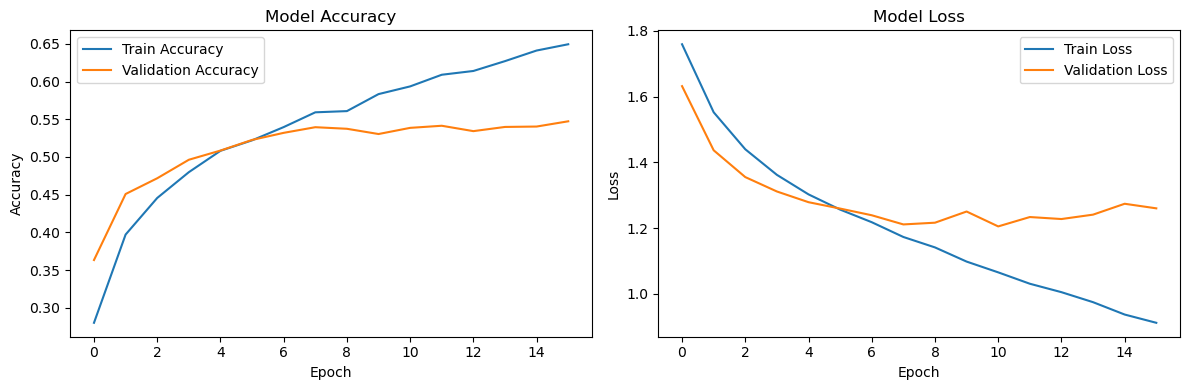

In [8]:
# Plot Training History
# Plot training & validation accuracy and loss values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [9]:
# Real-Time Emotion Recognition
# Load the trained model
from tensorflow.keras.models import load_model

model = load_model('emotion_recognition_model.h5')

# Initialize the webcam
cap = cv2.VideoCapture(0)

# Load cascade classifier for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

emotion_labels = emotion_categories

print("Starting real-time emotion recognition. Press 'q' to exit.")

while True:
    # Capture frame
    ret, frame = cap.read()
    if not ret:
        break

    # Convert the frame to grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces
    faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5)

    for (x, y, w, h) in faces:
        # Draw rectangle around the face
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)

        # Extract the face
        face = gray_frame[y:y + h, x:x + w]
        face_resized = cv2.resize(face, (48, 48)) / 255.0  # Resize and normalize
        face_reshaped = face_resized.reshape(1, 48, 48, 1)  # Reshape for model input

        # Predict emotion
        predictions = model.predict(face_reshaped)
        emotion_index = np.argmax(predictions)
        emotion = emotion_labels[emotion_index]

        # Display emotion on the frame
        cv2.putText(frame, emotion, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 255), 2)

    # Show the frame
    cv2.imshow('Emotion Recognition', frame)

    # Exit condition
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Clean up
cap.release()
cv2.destroyAllWindows()

Starting real-time emotion recognition. Press 'q' to exit.
1/1 [==============================] - 0s 33ms/step
